# Identification

### Date: 02/12/2022
### Name: Rémy DUMOULIN
### E-mail: remy.dumoulin@epfedu.fr

# Imports

In [2]:
import json
import tensorflow as tf
import pandas as pd 
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters

In [4]:
vocab_size = 100000
embedding_dim = 16
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 43410

# Load data

In [5]:
df = pd.read_csv ('go_emotions_dataset.csv')
df

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,ee6pagw,Everyone likes [NAME].,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,ef28nod,Well when you’ve imported about a gazillion of...,False,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
211222,ee8hse1,That looks amazing,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,edrhoxh,The FDA has plenty to criticize. But like here...,False,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This version of the dataset has over 200k comments. Lets restrict it to the 58 000 expected reddit comments only.

# Overview of the data

In [12]:
print(df['text'][0])
print(df['text'][1])
print(df['text'][2])

That game hurt.
 >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" 
You do right, if you don't care then fuck 'em!


In [13]:
df.shape

(211225, 31)

In [6]:
df = df.drop_duplicates(subset=['text'],ignore_index=True)
df

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57727,eed7qdq,He called [NAME] to the Steelers and was outsp...,False,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
57728,ef0lnq5,I didn’t even notice that one. I noticed the b...,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
57729,edirq0m,"Thanks, [NAME]",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57730,ee6pagw,Everyone likes [NAME].,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57732 entries, 0 to 57731
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    57732 non-null  object
 1   text                  57732 non-null  object
 2   example_very_unclear  57732 non-null  bool  
 3   admiration            57732 non-null  int64 
 4   amusement             57732 non-null  int64 
 5   anger                 57732 non-null  int64 
 6   annoyance             57732 non-null  int64 
 7   approval              57732 non-null  int64 
 8   caring                57732 non-null  int64 
 9   confusion             57732 non-null  int64 
 10  curiosity             57732 non-null  int64 
 11  desire                57732 non-null  int64 
 12  disappointment        57732 non-null  int64 
 13  disapproval           57732 non-null  int64 
 14  disgust               57732 non-null  int64 
 15  embarrassment         57732 non-null

# Pre-processing

In [7]:
comments = df['text']
labels = df.drop(['text','id','example_very_unclear'],axis=1)

In [8]:
training_comments = comments[0:43410]
training_labels = labels[0:43410]
testing_comments = comments[43410:48837]
testing_labels = labels[43410:48837]
validation_comments = comments[48837:54264]
validation_labels = labels[48837:54264]
print(training_comments.shape)
print(testing_comments.shape)
print(validation_comments.shape)

(43410,)
(5427,)
(5427,)


In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_comments)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_comments)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_comments)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_comments)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

# Model Training

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(28, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 16)           1600000   
                                                                 
 lstm_4 (LSTM)               (None, 300, 64)           20736     
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 28)                1820      
                                                                 
Total params: 1,647,388
Trainable params: 1,647,388
Non-trainable params: 0
_________________________________________________________________


In [22]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Epoch 1/30
1357/1357 [==============================] - 41s 30ms/step - loss: 0.1412 - accuracy: 0.3364 - val_loss: 0.1410 - val_accuracy: 0.3475
Epoch 2/30
1357/1357 [==============================] - 41s 30ms/step - loss: 0.1346 - accuracy: 0.3558 - val_loss: 0.1383 - val_accuracy: 0.3597
Epoch 3/30
1357/1357 [==============================] - 42s 31ms/step - loss: 0.1281 - accuracy: 0.3853 - val_loss: 0.1376 - val_accuracy: 0.3656
Epoch 4/30
1357/1357 [==============================] - 41s 30ms/step - loss: 0.1222 - accuracy: 0.4135 - val_loss: 0.1378 - val_accuracy: 0.3647
Epoch 5/30
1357/1357 [==============================] - 41s 30ms/step - loss: 0.1170 - accuracy: 0.4383 - val_loss: 0.1386 - val_accuracy: 0.3457
Epoch 6/30
1357/1357 [==============================] - 41s 30ms/step - loss: 0.1123 - accuracy: 0.4589 - val_loss: 0.1409 - val_accuracy: 0.3448
Epoch 7/30
1357/1357 [==============================] - 41s 31ms/step - loss: 0.1077 - accuracy: 0.4837 - val_loss: 0.1423 -

##Loss and Accuracy curves

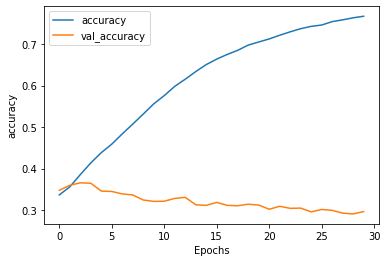

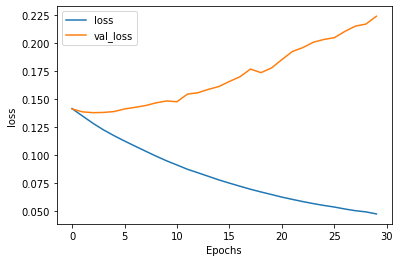

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

This model has the best training accuracy so let's choose it and tune it by reducing the overfitting

## Evaluation on the test set

In [37]:
model.evaluate(testing_padded,testing_labels)

170/170 [==============================] - 3s 16ms/step - loss: 0.2247 - accuracy: 0.2945


[0.22473353147506714, 0.2944536507129669]

#Model upgrades

## Pretrained dictionnary

In [11]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.9 MB/s 
     |████████████████████████████████| 5.8 MB 11.4 MB/s 
     |████████████████████████████████| 1.3 MB 35.2 MB/s 
     |████████████████████████████████| 182 kB 64.7 MB/s 
     |████████████████████████████████| 7.6 MB 60.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=74e9119edba3241ff1e0602a7c56c0c811e50804503c7563583f794dfc3a3a00
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [12]:
from sentence_transformers import SentenceTransformer

text_encoder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

embeddings = text_encoder.encode(comments)
training_embeddings = embeddings[0:43410]
validation_embeddings = embeddings[43410:48837]
testing_embeddings = embeddings[48837:54264]

print(training_embeddings.shape)
print(validation_embeddings.shape)
print(testing_embeddings.shape)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

(43410, 384)
(5427, 384)
(5427, 384)


In [13]:
training_embeddings_3d = training_embeddings.reshape(43410,1,384)
validation_embeddings_3d = validation_embeddings.reshape(5427,1,384)
testing_embeddings_3d = testing_embeddings.reshape(5427,1,384)

In [14]:
model_embed = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,input_shape=(1,384),return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(28, activation='sigmoid')
])
model_embed.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
num_epochs = 30
history_embed = model_embed.fit(training_embeddings_3d, training_labels, epochs=num_epochs, validation_data=(validation_embeddings_3d, validation_labels))

Epoch 1/30
1357/1357 [==============================] - 20s 9ms/step - loss: 0.1795 - accuracy: 0.2514 - val_loss: 0.1601 - val_accuracy: 0.2650
Epoch 2/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1474 - accuracy: 0.2995 - val_loss: 0.1728 - val_accuracy: 0.2261
Epoch 3/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1388 - accuracy: 0.3248 - val_loss: 0.1821 - val_accuracy: 0.2021
Epoch 4/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1333 - accuracy: 0.3426 - val_loss: 0.1869 - val_accuracy: 0.1879
Epoch 5/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1305 - accuracy: 0.3522 - val_loss: 0.1897 - val_accuracy: 0.1898
Epoch 6/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1285 - accuracy: 0.3601 - val_loss: 0.1933 - val_accuracy: 0.1902
Epoch 7/30
1357/1357 [==============================] - 11s 8ms/step - loss: 0.1270 - accuracy: 0.3663 - val_loss: 0.1948 - val_ac

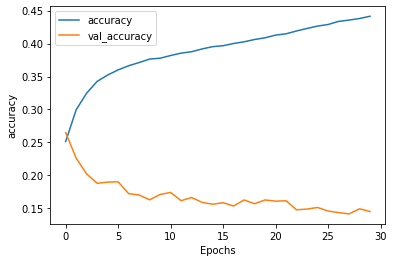

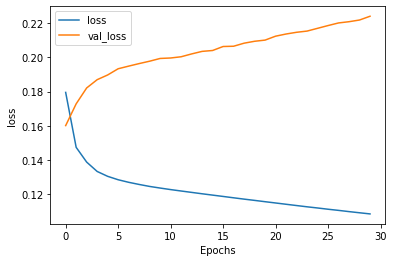

In [18]:
plot_graphs(history_embed, "accuracy")
plot_graphs(history_embed, "loss")

## Data augmentation

In [19]:
!pip install textattack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 4.8 MB/s 
     |████████████████████████████████| 41.4 MB 1.2 MB/s 
     |████████████████████████████████| 365 kB 63.7 MB/s 
     |████████████████████████████████| 125 kB 58.3 MB/s 
     |████████████████████████████████| 401 kB 46.5 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 
     |████████████████████████████████| 3.6 MB 59.6 MB/s 
     |████████████████████████████████| 769 kB 50.8 MB/s 
     |████████████████████████████████| 132 kB 54.4 MB/s 
     |████████████████████████████████| 212 kB 52.3 MB/s 
     |████████████████████████████████| 95 kB 4.0 MB/s 
     |████████████████████████████████| 127 kB 22.4 MB/s 
     |████████████████████████████████| 1.6 MB 41.0 MB/s 
     |████████████████████████████████| 981 kB 47.3 MB/s 
     |████████████████████████████████| 19.7 MB 1.4 MB/s 
     |██████████████████████████████

In [34]:
from textattack.augmentation import EmbeddingAugmenter
wna_aug = EmbeddingAugmenter()

arr_comments = []
for cmt in training_comments :
  augmented_sentence = wna_aug.augment(cmt)
  arr_comments.append(augmented_sentence)
augmented_comments = pd.Series(arr_comments)

In [35]:
#Let's make sure the comments were correctly augmented
new_comments = training_comments.compare(augmented_comments)
new_comments

,self,other
0,That game hurt.,[That game harmed.]
1,>sexuality shouldn’t be a grouping category I...,[ >sexuality shouldn’t be a group category It ...
2,"You do right, if you don't care then fuck 'em!","[You do right, if you don't care then dammit '..."
3,Man I love reddit.,[Males I love reddit.]
4,"[NAME] was nowhere near them, he was by the Fa...","[[DENOMINATION] was nowhere near them, he was ..."
...,...,...
43405,"Not defending the poor choice, but maybe he th...","[Not defending the poor choice, but maybe he t..."
43406,just asking a question... like I said I haven'...,[just asking a matter... like I said I haven't...
43407,are u ugly?,[are u horrendous?]
43408,Don’t worry about the baby but yes worry about...,[Don’t worry about the baby but yea worry abou...


In [33]:
### augmenter that randomly deletes or replace letters from the sentences

from textattack.transformations import WordSwapRandomCharacterDeletion, WordSwapQWERTY, CompositeTransformation
from textattack.constraints.pre_transformation import RepeatModification, StopwordModification
from textattack.augmentation import Augmenter

transformation = CompositeTransformation([WordSwapRandomCharacterDeletion(), WordSwapQWERTY()])
constraints = [RepeatModification(), StopwordModification()]

# initiate augmenter
augmenter = Augmenter(
    transformation=transformation,
    constraints=constraints,
    pct_words_to_swap=0.5,
    transformations_per_example=1
)
# additional parameters can be modified if not during initiation
augmenter.enable_advanced_metrics = True
augmenter.fast_augment = True
augmenter.high_yield = True

arr_comments = []
for cmt in training_comments :
  augmented_sentence = augmenter.augment(cmt)
  arr_comments.append(augmented_sentence)
augmented_comments = pd.Series(arr_comments)
augmented_comments = augmenter.augment(training_comments)

TypeError: ignored

In [48]:
training_comments_augmented = pd.concat([training_comments,augmented_comments], ignore_index=True)

training_labels = pd.DataFrame(training_labels)
training_labels_augmented = pd.concat([training_labels,training_labels], ignore_index=True)

In [52]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_comments_augmented)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_comments_augmented)
training_padded_augmented = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded_augmented = np.array(training_padded_augmented)

In [56]:
model_aug = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3, noise_shape=None),
    tf.keras.layers.Dense(28, activation='sigmoid')
])
model_aug.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [59]:
num_epochs = 4
history_aug = model_aug.fit(training_padded_augmented, training_labels_augmented, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Epoch 1/4
2714/2714 [==============================] - 1200s 442ms/step - loss: 0.1571 - accuracy: 0.2789 - val_loss: 0.1453 - val_accuracy: 0.3457
Epoch 2/4
2714/2714 [==============================] - 1192s 439ms/step - loss: 0.1441 - accuracy: 0.3256 - val_loss: 0.1419 - val_accuracy: 0.3435
Epoch 3/4
2714/2714 [==============================] - 1199s 442ms/step - loss: 0.1281 - accuracy: 0.3654 - val_loss: 0.1412 - val_accuracy: 0.3484
Epoch 4/4
2714/2714 [==============================] - 1228s 452ms/step - loss: 0.1173 - accuracy: 0.4169 - val_loss: 0.1413 - val_accuracy: 0.3427


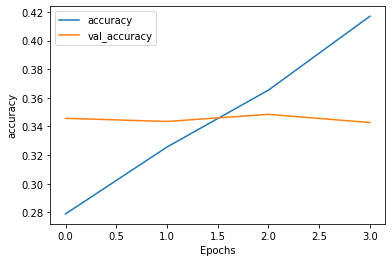

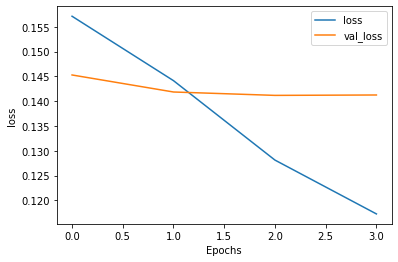

In [60]:
plot_graphs(history_aug, "accuracy")
plot_graphs(history_aug, "loss")

In [61]:
model_aug.evaluate(testing_padded,testing_labels)

170/170 [==============================] - 16s 94ms/step - loss: 0.1414 - accuracy: 0.3451


[0.14137698709964752, 0.345126211643219]

#Previous models

In [39]:
clf = tf.keras.Sequential()

clf.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

clf.add(tf.keras.layers.Convolution1D(64, (3),padding='same', activation='relu'))
clf.add(tf.keras.layers.MaxPool1D(pool_size=(2)))

clf.add(tf.keras.layers.Convolution1D(32, (3),padding='same', activation='relu'))
clf.add(tf.keras.layers.MaxPool1D(pool_size=(2)))

clf.add(tf.keras.layers.Convolution1D(16, (3),padding='same', activation='relu'))
clf.add(tf.keras.layers.MaxPool1D(pool_size=(2)))

clf.add(tf.keras.layers.Convolution1D(8, (3),padding='same', activation='relu'))
clf.add(tf.keras.layers.MaxPool1D(pool_size=(2)))

clf.add(tf.keras.layers.Flatten())

clf.add(tf.keras.layers.Dense(activation='relu', units=128))
clf.add(tf.keras.layers.Dense(activation='sigmoid', units=28))

clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
num_epochs = 30
history_clf = clf.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Epoch 1/30
1357/1357 [==============================] - 91s 66ms/step - loss: 0.1638 - accuracy: 0.2676 - val_loss: 0.1439 - val_accuracy: 0.3374
Epoch 2/30
1357/1357 [==============================] - 83s 61ms/step - loss: 0.1385 - accuracy: 0.3524 - val_loss: 0.1352 - val_accuracy: 0.3800
Epoch 3/30
1357/1357 [==============================] - 83s 61ms/step - loss: 0.1294 - accuracy: 0.3786 - val_loss: 0.1341 - val_accuracy: 0.3846
Epoch 4/30
1357/1357 [==============================] - 84s 62ms/step - loss: 0.1219 - accuracy: 0.4068 - val_loss: 0.1362 - val_accuracy: 0.3709
Epoch 5/30
1357/1357 [==============================] - 86s 64ms/step - loss: 0.1146 - accuracy: 0.4359 - val_loss: 0.1398 - val_accuracy: 0.3365
Epoch 6/30
1357/1357 [==============================] - 86s 63ms/step - loss: 0.1081 - accuracy: 0.4657 - val_loss: 0.1432 - val_accuracy: 0.3374
Epoch 7/30
1357/1357 [==============================] - 84s 62ms/step - loss: 0.1024 - accuracy: 0.4951 - val_loss: 0.1518 -

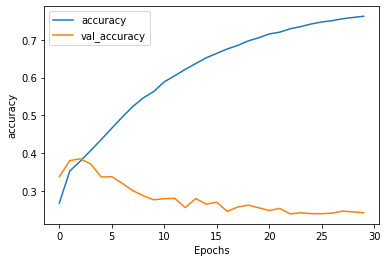

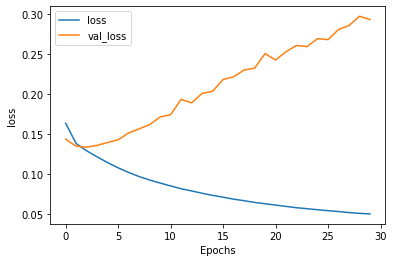

In [41]:
plot_graphs(history_clf, "accuracy")
plot_graphs(history_clf, "loss")

In [34]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(28, activation='sigmoid')
])
cnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
num_epochs = 30
history_cnn = cnn.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Epoch 1/30
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1821 - accuracy: 0.2435 - val_loss: 0.1583 - val_accuracy: 0.2753
Epoch 2/30
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1571 - accuracy: 0.2652 - val_loss: 0.1579 - val_accuracy: 0.2753
Epoch 3/30
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1569 - accuracy: 0.2652 - val_loss: 0.1580 - val_accuracy: 0.2753
Epoch 4/30
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1565 - accuracy: 0.2652 - val_loss: 0.1575 - val_accuracy: 0.2753
Epoch 5/30
1357/1357 [==============================] - 6s 4ms/step - loss: 0.1557 - accuracy: 0.2652 - val_loss: 0.1561 - val_accuracy: 0.2755
Epoch 6/30
1357/1357 [==============================] - 7s 5ms/step - loss: 0.1524 - accuracy: 0.2781 - val_loss: 0.1517 - val_accuracy: 0.3015
Epoch 7/30
1357/1357 [==============================] - 6s 5ms/step - loss: 0.1482 - accuracy: 0.3001 - val_loss: 0.1493 - val_accuracy:

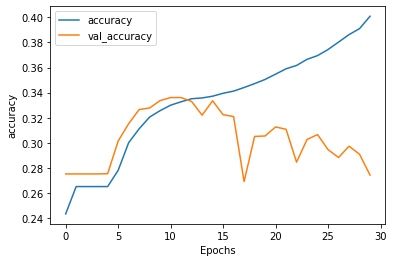

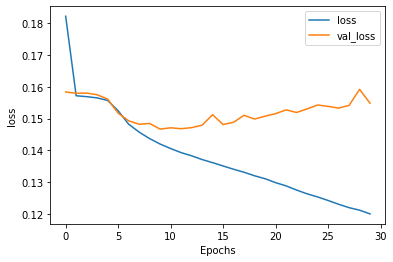

In [36]:
plot_graphs(history_cnn, "accuracy")
plot_graphs(history_cnn, "loss")

In [38]:
double_bidirectional = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(28, activation='sigmoid')
])
double_bidirectional.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [39]:
history_db = double_bidirectional.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels))

Epoch 1/30
1357/1357 [==============================] - 64s 44ms/step - loss: 0.1646 - accuracy: 0.2625 - val_loss: 0.1559 - val_accuracy: 0.2922
Epoch 2/30
1357/1357 [==============================] - 55s 40ms/step - loss: 0.1477 - accuracy: 0.3153 - val_loss: 0.1440 - val_accuracy: 0.3481
Epoch 3/30
1357/1357 [==============================] - 59s 44ms/step - loss: 0.1407 - accuracy: 0.3475 - val_loss: 0.1400 - val_accuracy: 0.3696
Epoch 4/30
1357/1357 [==============================] - 55s 40ms/step - loss: 0.1339 - accuracy: 0.3703 - val_loss: 0.1358 - val_accuracy: 0.3715
Epoch 5/30
1357/1357 [==============================] - 57s 42ms/step - loss: 0.1261 - accuracy: 0.3931 - val_loss: 0.1344 - val_accuracy: 0.3650
Epoch 6/30
1357/1357 [==============================] - 56s 41ms/step - loss: 0.1191 - accuracy: 0.4185 - val_loss: 0.1347 - val_accuracy: 0.3475
Epoch 7/30
1357/1357 [==============================] - 56s 41ms/step - loss: 0.1131 - accuracy: 0.4502 - val_loss: 0.1367 -

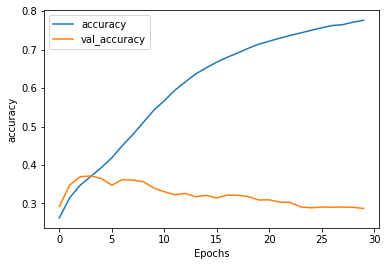

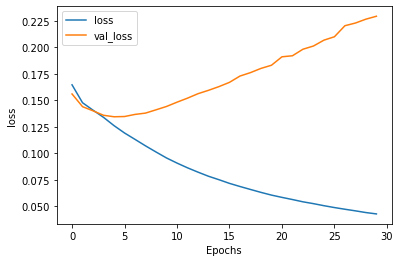

In [40]:
plot_graphs(history_db, "accuracy")
plot_graphs(history_db, "loss")